In [1]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/home/ra/Codes/multilang_timescale


In [2]:
import json

from typing import List
import h5py

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm import tqdm

In [3]:
from src.trainer import Trainer
from src.settings import TrainerConfig, SubjectConfig, FeatureConfig, ResultConfig

from src.plotting import plot_flatmap_from_mapper, plot_timeline_flatmaps

In [4]:
from himalaya import kernel_ridge
from himalaya.scoring import correlation_score_split, r2_score_split
from typing import Tuple
from multiprocessing import Pool

In [5]:
result_meta_dir = ".temp/result_meta"

In [6]:
# scanning result meta json files and put it into a dataframe
result_meta_files = os.listdir(result_meta_dir)
result_meta_files = [f for f in result_meta_files if f.endswith(".json")]
## read json and cast it into ResultConfig
result_meta_list = []
for f in result_meta_files:
    with open(os.path.join(result_meta_dir, f), "r") as f:
        result_config = ResultConfig(**json.load(f))
        result_meta_list.append(result_config.dict())

result_meta_df = pd.DataFrame(result_meta_list)

# add result_meta_files to result_meta_df
result_meta_df["result_meta_file"] = [
    os.path.join(result_meta_dir, f) for f in result_meta_files
]

In [7]:
result_meta_df.head()

,subject_config_path,feature_config_path,trainer_config_path,result_dir,hyperparam_path,stats_path,plot_dir,result_meta_file
0,.temp/config/subject/subject-07-reading.json,.temp/config/feature/BERT-all_timescales-7-fea...,.temp/config/train/trainer_config.json,.temp/result/7904b592-f99d-44e9-befe-6c5b81ed8984,.temp/result/7904b592-f99d-44e9-befe-6c5b81ed8...,.temp/result/7904b592-f99d-44e9-befe-6c5b81ed8...,.temp/result/7904b592-f99d-44e9-befe-6c5b81ed8...,.temp/result_meta/7904b592-f99d-44e9-befe-6c5b...
1,.temp/config/subject/subject-07-reading.json,.temp/config/feature/mBERT-all_timescales-7-fe...,.temp/config/train/trainer_config.json,.temp/result/145fe775-7b59-4c6e-b037-253defdc54b8,.temp/result/145fe775-7b59-4c6e-b037-253defdc5...,.temp/result/145fe775-7b59-4c6e-b037-253defdc5...,.temp/result/145fe775-7b59-4c6e-b037-253defdc5...,.temp/result_meta/145fe775-7b59-4c6e-b037-253d...


In [8]:
result_meta_df["trainer_config_path"].unique()

array(['.temp/config/train/trainer_config.json'], dtype=object)

In [9]:
result_meta_df["subject_config_path"].unique()

array(['.temp/config/subject/subject-07-reading.json'], dtype=object)

In [10]:
result_meta_df["feature_config_path"].unique()

array(['.temp/config/feature/BERT-all_timescales-7-feature_config.json',
       '.temp/config/feature/mBERT-all_timescales-7-feature_config.json'],
      dtype=object)

In [11]:
# select some results
selected_train_config = [".temp/config/train/trainer_config.json"]
selected_feature_config = [
    ".temp/config/feature/BERT-all_timescales-7-feature_config.json",
    ".temp/config/feature/mBERT-all_timescales-7-feature_config.json",
]
selected_subject_config = [".temp/config/subject/subject-07-reading.json"]

# now select dataframe
selected_result_meta_df = result_meta_df.query(
    "trainer_config_path in @selected_train_config and \
                                                feature_config_path in @selected_feature_config and \
                                                subject_config_path in @selected_subject_config"
)

In [12]:
selected_result_meta_df

,subject_config_path,feature_config_path,trainer_config_path,result_dir,hyperparam_path,stats_path,plot_dir,result_meta_file
0,.temp/config/subject/subject-07-reading.json,.temp/config/feature/BERT-all_timescales-7-fea...,.temp/config/train/trainer_config.json,.temp/result/7904b592-f99d-44e9-befe-6c5b81ed8984,.temp/result/7904b592-f99d-44e9-befe-6c5b81ed8...,.temp/result/7904b592-f99d-44e9-befe-6c5b81ed8...,.temp/result/7904b592-f99d-44e9-befe-6c5b81ed8...,.temp/result_meta/7904b592-f99d-44e9-befe-6c5b...
1,.temp/config/subject/subject-07-reading.json,.temp/config/feature/mBERT-all_timescales-7-fe...,.temp/config/train/trainer_config.json,.temp/result/145fe775-7b59-4c6e-b037-253defdc54b8,.temp/result/145fe775-7b59-4c6e-b037-253defdc5...,.temp/result/145fe775-7b59-4c6e-b037-253defdc5...,.temp/result/145fe775-7b59-4c6e-b037-253defdc5...,.temp/result_meta/145fe775-7b59-4c6e-b037-253d...


# Refit and Evaluate

In [12]:
# iter over selected_result_meta_df
for i, row in selected_result_meta_df.iterrows():
    result_config_path = row["result_meta_file"]
    
    ## refit model 
    print(f"Refitting model for {result_config_path}")
    
    trainer = Trainer(result_config_json=result_config_path)
    trainer.refit_and_evaluate()
    
    

Refitting model for .temp/result_meta/7904b592-f99d-44e9-befe-6c5b81ed8984.json
refitting...
predicting in batches...
computing scores...
computing permutation test...
computing timescale selectivity...
saving stat...


/home/ra/Codes/multilang_timescale/src/utils.py:147: RuntimeWarning: invalid value encountered in divide
  normalized_scores = np.nan_to_num(nz_scores / score_sum)


Refitting model for .temp/result_meta/145fe775-7b59-4c6e-b037-253defdc54b8.json
refitting...
predicting in batches...
computing scores...
computing permutation test...
computing timescale selectivity...
saving stat...


/home/ra/Codes/multilang_timescale/src/utils.py:147: RuntimeWarning: invalid value encountered in divide
  normalized_scores = np.nan_to_num(nz_scores / score_sum)


# Plotting

In [33]:
bert_configs = selected_result_meta_df.iloc[0]
mbert_configs = selected_result_meta_df.iloc[1] 

In [34]:
subject_config = bert_configs["subject_config_path"]
subject_config = SubjectConfig(**json.load(open(subject_config, "r"))).dict()

mapper_file = subject_config['sub_fmri_mapper_path']
mapper_file = "/media/data/dataset/timescale/fmri/deniz2019_old/subject07_mappers.hdf"

bert_stats = np.load(bert_configs['stats_path'])
mbert_stats = np.load(mbert_configs['stats_path'])


In [15]:
def get_bh_invalid_voxels(pvalues: np.ndarray, alpha: float):

    num_values = len(pvalues)
    pvalues_sorted = np.sort(pvalues)
    max_p = pvalues_sorted[
        np.argmax(
            np.where(
                pvalues_sorted <= ((np.arange(1, num_values + 1) / num_values) * alpha)
            )
        )
    ]
    
    return pvalues > max_p

In [29]:
def put_values_on_mask(
    value_to_be_stored: np.ndarray,
    p_values: np.ndarray,
    ev_mask: np.ndarray,
    alpha: float = 0.05,
):
    whole_voxel = np.full(ev_mask.shape, np.nan)

    invalid_p_values = get_bh_invalid_voxels(p_values, alpha)

    value_to_be_stored[invalid_p_values] = np.nan

    whole_voxel[ev_mask] = value_to_be_stored
    
    valid_voxels = np.where(~np.isnan(whole_voxel)) 
    return whole_voxel, valid_voxels

In [38]:
bert_significant_voxels, bert_valid_voxels = put_values_on_mask(
    bert_stats["test_r2_selectivity_mask"],
    bert_stats["test_p_values_r2_mask"],
    bert_stats["mask"], alpha=0.05)

In [39]:
mbert_significant_voxels, mbert_valid_voxels = put_values_on_mask(
    mbert_stats["test_r2_selectivity_mask"],
    mbert_stats["test_p_values_r2_mask"],
    mbert_stats["mask"], alpha=0.05)

<Axes: >

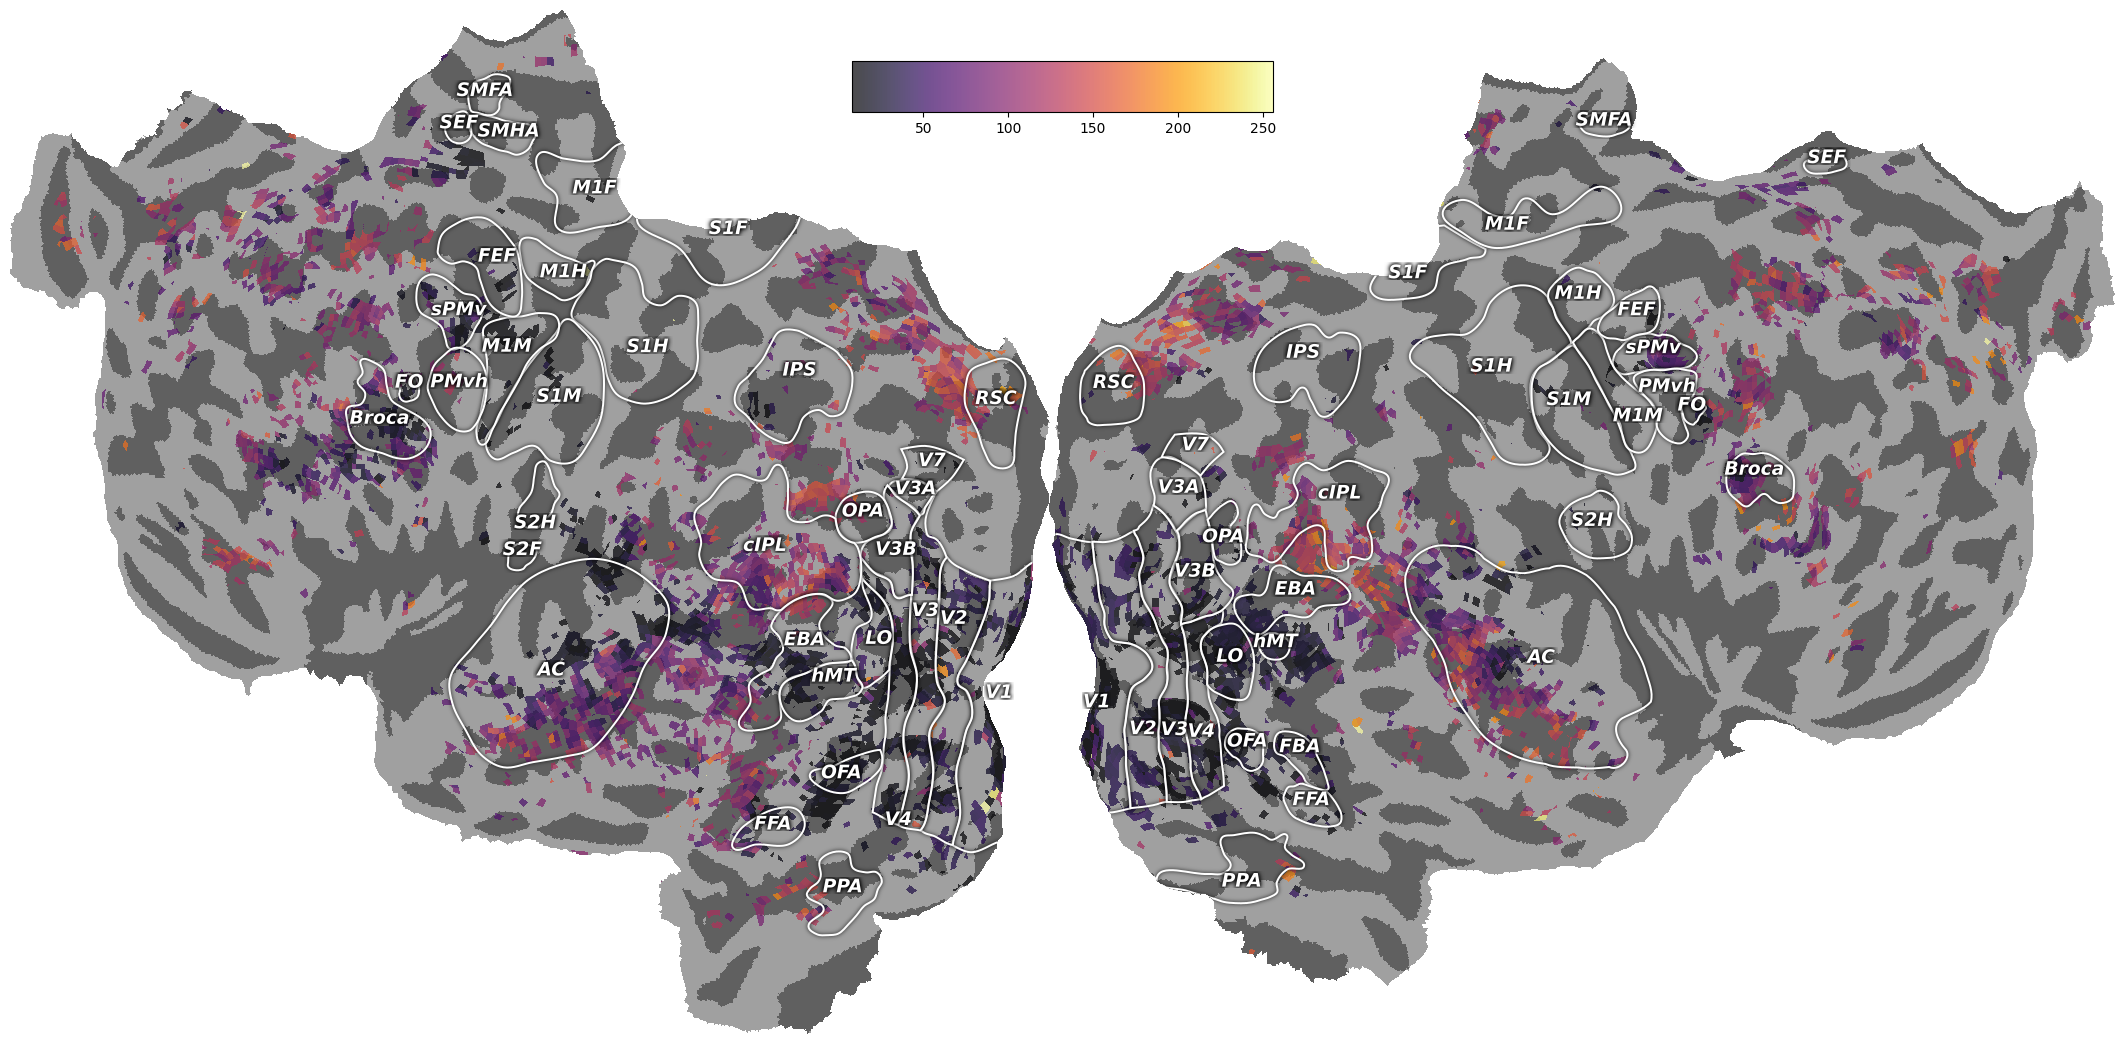

In [40]:
plot_flatmap_from_mapper(bert_significant_voxels, mapper,vmin=8, vmax=256)

<Axes: >

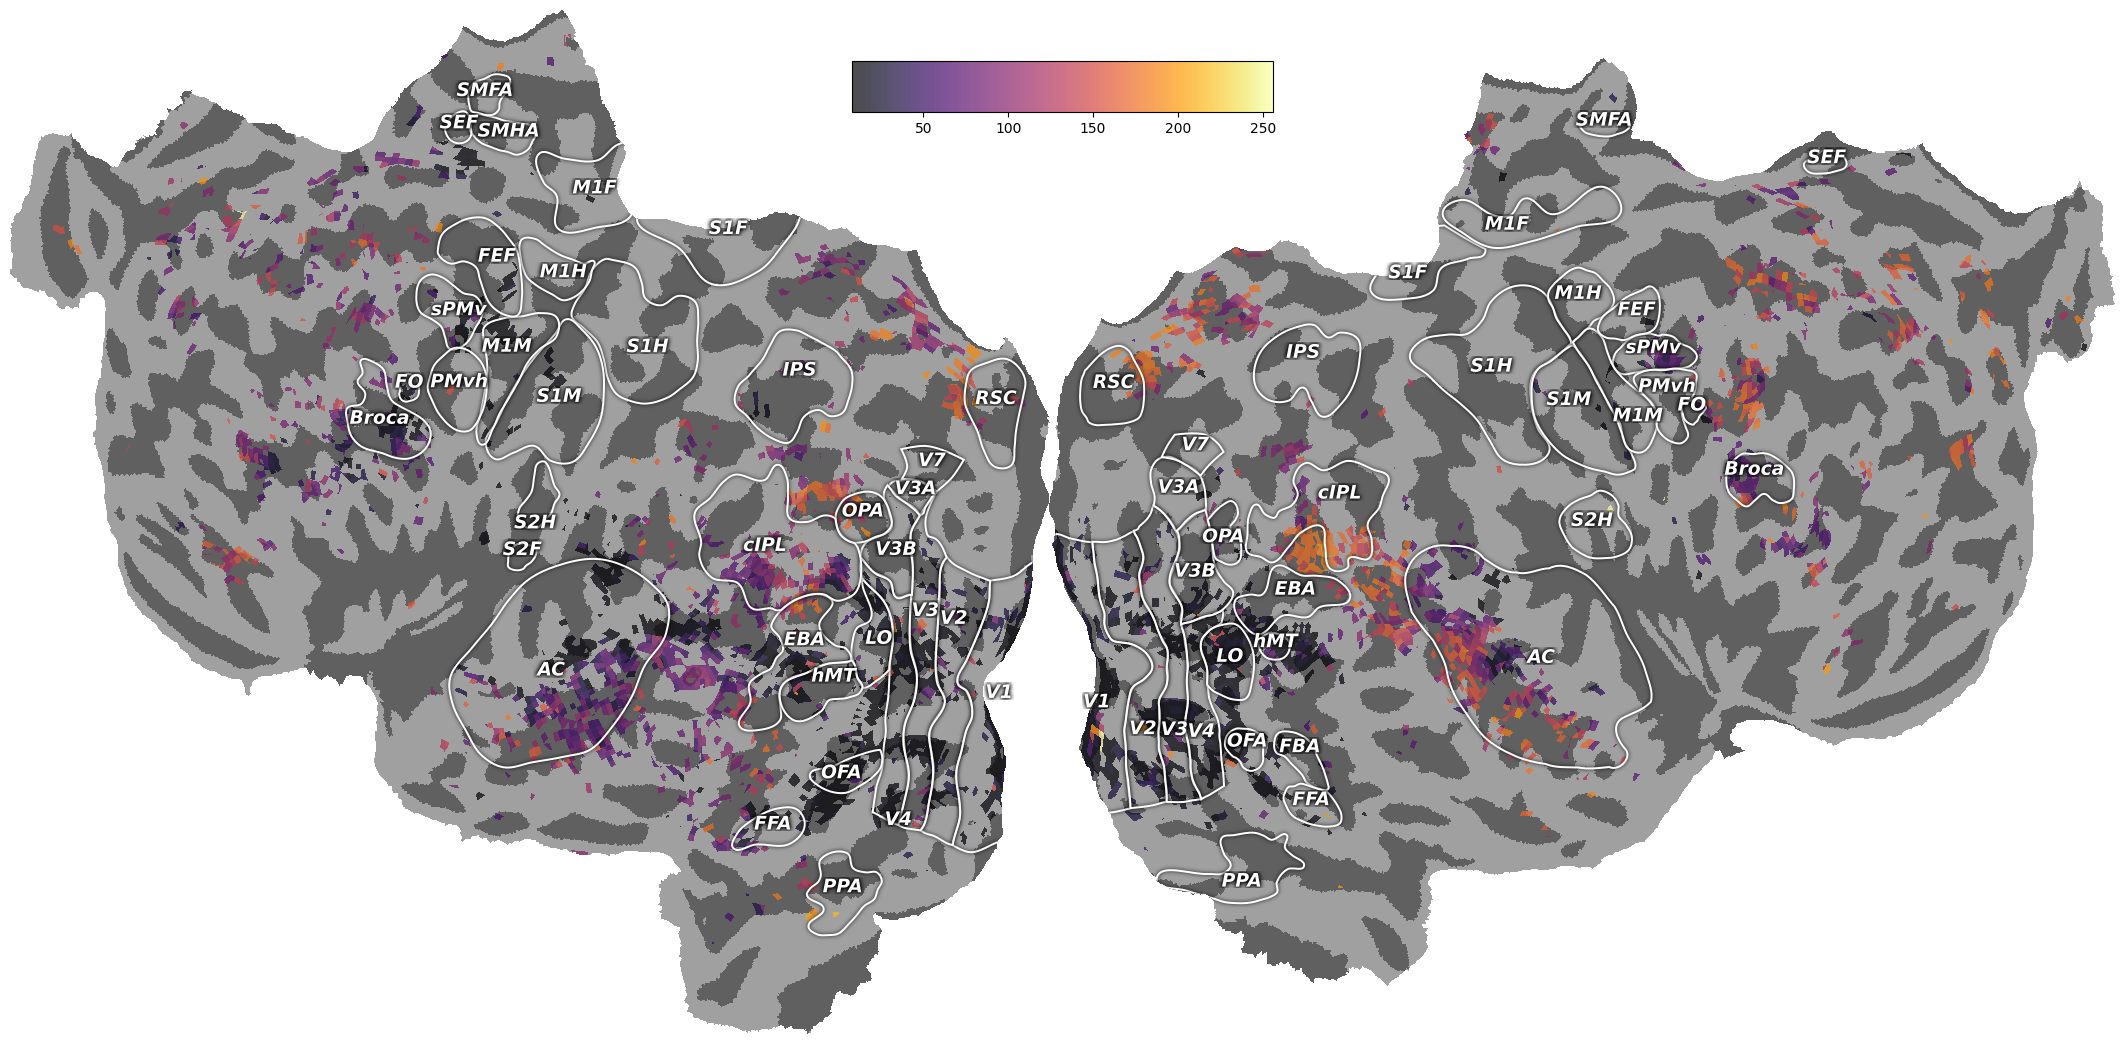

In [41]:
plot_flatmap_from_mapper(mbert_significant_voxels, mapper,vmin=8, vmax=256)

In [49]:
# get the same significant voxels for both models
common_voxels = np.intersect1d(bert_valid_voxels, mbert_valid_voxels)

In [50]:
significant_bert_voxels = bert_significant_voxels[common_voxels]    
significant_mbert_voxels = mbert_significant_voxels[common_voxels]

# filter out value > 256

<Axes: >

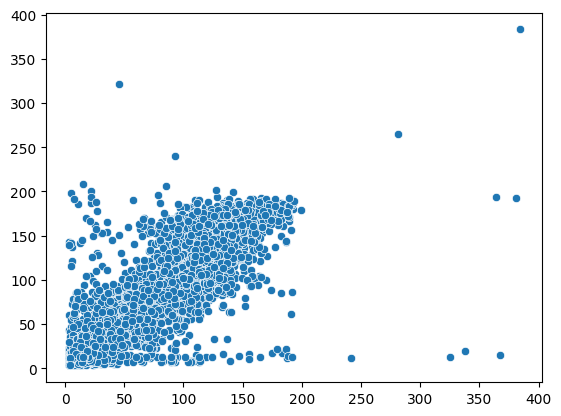

In [51]:
# scatter plot
import seaborn as sns

sns.scatterplot(x=significant_bert_voxels, y=significant_mbert_voxels, )